## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)     
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 48898
# species = 

endpointURL = "http://localhost:3030/REACTOME_BTAURUS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,99876
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,36721
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,24020
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,23049
4,http://www.biopax.org/release/biopax-level3.owl#Protein,19256
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,16961
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,16961
7,http://www.biopax.org/release/biopax-level3.owl#Evidence,9618
8,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,9591
9,http://www.biopax.org/release/biopax-level3.owl#Complex,9412


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,502


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,8910


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4021


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4889


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,396


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,248


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3773


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,3135


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    9412.000000
mean        2.311305
std         2.876553
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

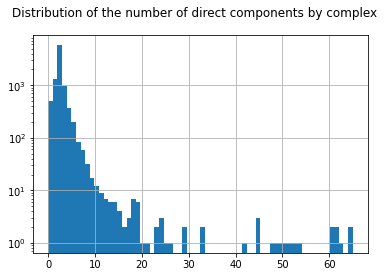

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

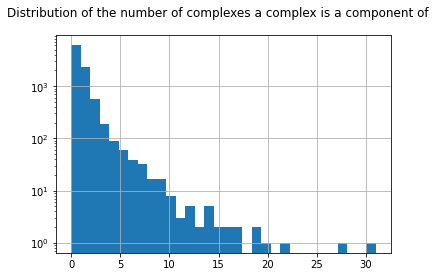

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,12919


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,5592


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,4734


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7144


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7617


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1


How many cliques? <a class="anchor" id="cliques"></a>

In [23]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [24]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [25]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes

In [26]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [27]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [28]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.22695350646972656	http://www.reactome.org/biopax/81/48898#Complex11
1	0.5646610260009766	http://www.reactome.org/biopax/81/48898#Complex14
2	0.9504506587982178	http://www.reactome.org/biopax/81/48898#Complex18
3	1.766204833984375	http://www.reactome.org/biopax/81/48898#Complex21
4	2.237637758255005	http://www.reactome.org/biopax/81/48898#Complex22
5	2.495882034301758	http://www.reactome.org/biopax/81/48898#Complex23
6	2.9018287658691406	http://www.reactome.org/biopax/81/48898#Complex19
7	3.347661256790161	http://www.reactome.org/biopax/81/48898#Complex30
8	3.6627962589263916	http://www.reactome.org/biopax/81/48898#Complex35
9	3.9491350650787354	http://www.reactome.org/biopax/81/48898#Complex36
10	4.196211576461792	http://www.reactome.org/biopax/81/48898#Complex38
11	4.657668590545654	http://www.reactome.org/biopax/81/48898#Complex39
12	4.9634850025177	http://www.reactome.org/biopax/81/48898#Complex41
13	5.267611026763916	http://www.reactome.org/biopax/81/48898#Complex50
14	5.442837

114	252.87012648582458	http://www.reactome.org/biopax/81/48898#Complex245
115	256.262663602829	http://www.reactome.org/biopax/81/48898#Complex238
116	259.72825837135315	http://www.reactome.org/biopax/81/48898#Complex246
117	263.6405653953552	http://www.reactome.org/biopax/81/48898#Complex247
118	267.25943899154663	http://www.reactome.org/biopax/81/48898#Complex248
119	270.78184485435486	http://www.reactome.org/biopax/81/48898#Complex249
120	271.34929752349854	http://www.reactome.org/biopax/81/48898#Complex253
121	271.7797427177429	http://www.reactome.org/biopax/81/48898#Complex256
122	272.0831344127655	http://www.reactome.org/biopax/81/48898#Complex259
123	272.7799062728882	http://www.reactome.org/biopax/81/48898#Complex262
124	273.6074616909027	http://www.reactome.org/biopax/81/48898#Complex264
125	274.42785382270813	http://www.reactome.org/biopax/81/48898#Complex266
126	275.3175709247589	http://www.reactome.org/biopax/81/48898#Complex268
127	275.74065709114075	http://www.reactome.org

226	300.58423376083374	http://www.reactome.org/biopax/81/48898#Complex622
227	300.76485109329224	http://www.reactome.org/biopax/81/48898#Complex623
228	300.9586408138275	http://www.reactome.org/biopax/81/48898#Complex625
229	301.1410710811615	http://www.reactome.org/biopax/81/48898#Complex626
230	301.2788314819336	http://www.reactome.org/biopax/81/48898#Complex630
231	301.42914724349976	http://www.reactome.org/biopax/81/48898#Complex632
232	301.58748984336853	http://www.reactome.org/biopax/81/48898#Complex635
233	301.73930406570435	http://www.reactome.org/biopax/81/48898#Complex636
234	301.8776798248291	http://www.reactome.org/biopax/81/48898#Complex638
235	301.9697754383087	http://www.reactome.org/biopax/81/48898#Complex639
236	302.0806212425232	http://www.reactome.org/biopax/81/48898#Complex640
237	302.1824324131012	http://www.reactome.org/biopax/81/48898#Complex643
238	302.27191615104675	http://www.reactome.org/biopax/81/48898#Complex645
239	302.37078046798706	http://www.reactome.or

339	349.80094146728516	http://www.reactome.org/biopax/81/48898#Complex969
340	349.9595437049866	http://www.reactome.org/biopax/81/48898#Complex971
341	350.0937445163727	http://www.reactome.org/biopax/81/48898#Complex972
342	350.2094349861145	http://www.reactome.org/biopax/81/48898#Complex973
343	350.3356056213379	http://www.reactome.org/biopax/81/48898#Complex981
344	350.50616335868835	http://www.reactome.org/biopax/81/48898#Complex983
345	350.8754322528839	http://www.reactome.org/biopax/81/48898#Complex984
346	351.0538954734802	http://www.reactome.org/biopax/81/48898#Complex986
347	351.1630702018738	http://www.reactome.org/biopax/81/48898#Complex988
348	351.31383085250854	http://www.reactome.org/biopax/81/48898#Complex989
349	351.452431678772	http://www.reactome.org/biopax/81/48898#Complex991
350	352.25026774406433	http://www.reactome.org/biopax/81/48898#Complex996
351	352.9027395248413	http://www.reactome.org/biopax/81/48898#Complex993
352	353.3029406070709	http://www.reactome.org/bi

450	461.9149281978607	http://www.reactome.org/biopax/81/48898#Complex1159
451	462.206725358963	http://www.reactome.org/biopax/81/48898#Complex1161
452	462.6218435764313	http://www.reactome.org/biopax/81/48898#Complex1162
453	463.3223834037781	http://www.reactome.org/biopax/81/48898#Complex1166
454	464.73011898994446	http://www.reactome.org/biopax/81/48898#Complex1167
455	464.96312379837036	http://www.reactome.org/biopax/81/48898#Complex1168
456	465.3265345096588	http://www.reactome.org/biopax/81/48898#Complex1169
457	466.6608626842499	http://www.reactome.org/biopax/81/48898#Complex1170
458	466.9411778450012	http://www.reactome.org/biopax/81/48898#Complex1172
459	467.35082030296326	http://www.reactome.org/biopax/81/48898#Complex1173
460	468.76246190071106	http://www.reactome.org/biopax/81/48898#Complex1176
461	468.9017493724823	http://www.reactome.org/biopax/81/48898#Complex1179
462	469.0536847114563	http://www.reactome.org/biopax/81/48898#Complex1181
463	469.1864986419678	http://www.re

562	495.6180348396301	http://www.reactome.org/biopax/81/48898#Complex1420
563	495.6990010738373	http://www.reactome.org/biopax/81/48898#Complex1421
564	495.823349237442	http://www.reactome.org/biopax/81/48898#Complex1422
565	495.94596886634827	http://www.reactome.org/biopax/81/48898#Complex1423
566	496.0429949760437	http://www.reactome.org/biopax/81/48898#Complex1432
567	496.20388650894165	http://www.reactome.org/biopax/81/48898#Complex1434
568	496.52255415916443	http://www.reactome.org/biopax/81/48898#Complex1435
569	496.7956178188324	http://www.reactome.org/biopax/81/48898#Complex1437
570	497.0082528591156	http://www.reactome.org/biopax/81/48898#Complex1439
571	497.2082543373108	http://www.reactome.org/biopax/81/48898#Complex1452
572	497.4095366001129	http://www.reactome.org/biopax/81/48898#Complex1443
573	497.6012773513794	http://www.reactome.org/biopax/81/48898#Complex1446
574	497.7837052345276	http://www.reactome.org/biopax/81/48898#Complex1449
575	497.97985458374023	http://www.re

674	521.2581763267517	http://www.reactome.org/biopax/81/48898#Complex1742
675	521.399870634079	http://www.reactome.org/biopax/81/48898#Complex1743
676	521.5043501853943	http://www.reactome.org/biopax/81/48898#Complex1745
677	521.6543633937836	http://www.reactome.org/biopax/81/48898#Complex1747
678	521.8874406814575	http://www.reactome.org/biopax/81/48898#Complex1749
679	522.0120840072632	http://www.reactome.org/biopax/81/48898#Complex1752
680	522.3349828720093	http://www.reactome.org/biopax/81/48898#Complex1753
681	522.6280195713043	http://www.reactome.org/biopax/81/48898#Complex1755
682	522.8855483531952	http://www.reactome.org/biopax/81/48898#Complex1758
683	522.9831655025482	http://www.reactome.org/biopax/81/48898#Complex1761
684	523.081146478653	http://www.reactome.org/biopax/81/48898#Complex1762
685	523.1825768947601	http://www.reactome.org/biopax/81/48898#Complex1764
686	523.3869881629944	http://www.reactome.org/biopax/81/48898#Complex1770
687	523.5717115402222	http://www.reactom

785	549.6966996192932	http://www.reactome.org/biopax/81/48898#Complex1945
786	549.7832207679749	http://www.reactome.org/biopax/81/48898#Complex1947
787	549.9197340011597	http://www.reactome.org/biopax/81/48898#Complex1949
788	550.062242269516	http://www.reactome.org/biopax/81/48898#Complex1954
789	550.1692199707031	http://www.reactome.org/biopax/81/48898#Complex1955
790	550.2722661495209	http://www.reactome.org/biopax/81/48898#Complex1958
791	550.4230816364288	http://www.reactome.org/biopax/81/48898#Complex1959
792	550.5280492305756	http://www.reactome.org/biopax/81/48898#Complex1962
793	550.6273214817047	http://www.reactome.org/biopax/81/48898#Complex1963
794	550.7455148696899	http://www.reactome.org/biopax/81/48898#Complex1964
795	550.8888556957245	http://www.reactome.org/biopax/81/48898#Complex1967
796	551.0045042037964	http://www.reactome.org/biopax/81/48898#Complex1970
797	551.257532119751	http://www.reactome.org/biopax/81/48898#Complex1972
798	551.384509563446	http://www.reactome

896	585.7986960411072	http://www.reactome.org/biopax/81/48898#Complex2138
897	585.9119305610657	http://www.reactome.org/biopax/81/48898#Complex2139
898	586.0863389968872	http://www.reactome.org/biopax/81/48898#Complex2141
899	586.2641668319702	http://www.reactome.org/biopax/81/48898#Complex2142
900	586.3738589286804	http://www.reactome.org/biopax/81/48898#Complex2144
901	586.5382130146027	http://www.reactome.org/biopax/81/48898#Complex2147
902	586.6906127929688	http://www.reactome.org/biopax/81/48898#Complex2145
903	586.8054645061493	http://www.reactome.org/biopax/81/48898#Complex2148
904	586.9155287742615	http://www.reactome.org/biopax/81/48898#Complex2151
905	587.0677714347839	http://www.reactome.org/biopax/81/48898#Complex2152
906	587.2264308929443	http://www.reactome.org/biopax/81/48898#Complex2154
907	587.4003810882568	http://www.reactome.org/biopax/81/48898#Complex2155
908	587.5925498008728	http://www.reactome.org/biopax/81/48898#Complex2163
909	587.7205319404602	http://www.react

1008	614.204446554184	http://www.reactome.org/biopax/81/48898#Complex2365
1009	614.3947067260742	http://www.reactome.org/biopax/81/48898#Complex2370
1010	614.6761066913605	http://www.reactome.org/biopax/81/48898#Complex2372
1011	615.0964205265045	http://www.reactome.org/biopax/81/48898#Complex2373
1012	615.5122547149658	http://www.reactome.org/biopax/81/48898#Complex2374
1013	615.7427289485931	http://www.reactome.org/biopax/81/48898#Complex2375
1014	615.910706281662	http://www.reactome.org/biopax/81/48898#Complex2377
1015	616.2241230010986	http://www.reactome.org/biopax/81/48898#Complex2378
1016	616.5505661964417	http://www.reactome.org/biopax/81/48898#Complex2379
1017	616.8752946853638	http://www.reactome.org/biopax/81/48898#Complex2380
1018	617.1944630146027	http://www.reactome.org/biopax/81/48898#Complex2381
1019	617.508683681488	http://www.reactome.org/biopax/81/48898#Complex2382
1020	617.8549871444702	http://www.reactome.org/biopax/81/48898#Complex2383
1021	618.17862200737	http://

1118	643.3855082988739	http://www.reactome.org/biopax/81/48898#Complex2558
1119	643.4950699806213	http://www.reactome.org/biopax/81/48898#Complex2560
1120	643.8158297538757	http://www.reactome.org/biopax/81/48898#Complex2561
1121	644.0934286117554	http://www.reactome.org/biopax/81/48898#Complex2565
1122	644.211511850357	http://www.reactome.org/biopax/81/48898#Complex2569
1123	644.3857028484344	http://www.reactome.org/biopax/81/48898#Complex2570
1124	644.6130192279816	http://www.reactome.org/biopax/81/48898#Complex2575
1125	644.8292047977448	http://www.reactome.org/biopax/81/48898#Complex2577
1126	645.0921764373779	http://www.reactome.org/biopax/81/48898#Complex2580
1127	645.392228603363	http://www.reactome.org/biopax/81/48898#Complex2582
1128	645.6070790290833	http://www.reactome.org/biopax/81/48898#Complex2583
1129	645.7146556377411	http://www.reactome.org/biopax/81/48898#Complex2584
1130	645.822847366333	http://www.reactome.org/biopax/81/48898#Complex2585
1131	645.928642988205	http:/

1228	668.5818915367126	http://www.reactome.org/biopax/81/48898#Complex2743
1229	668.8342719078064	http://www.reactome.org/biopax/81/48898#Complex2745
1230	669.0942513942719	http://www.reactome.org/biopax/81/48898#Complex2747
1231	669.4136989116669	http://www.reactome.org/biopax/81/48898#Complex2748
1232	669.7656393051147	http://www.reactome.org/biopax/81/48898#Complex2750
1233	669.8754253387451	http://www.reactome.org/biopax/81/48898#Complex2751
1234	670.0002830028534	http://www.reactome.org/biopax/81/48898#Complex2752
1235	670.143123626709	http://www.reactome.org/biopax/81/48898#Complex2753
1236	670.309965133667	http://www.reactome.org/biopax/81/48898#Complex2755
1237	670.4724748134613	http://www.reactome.org/biopax/81/48898#Complex2757
1238	670.5855097770691	http://www.reactome.org/biopax/81/48898#Complex2758
1239	670.710503578186	http://www.reactome.org/biopax/81/48898#Complex2763
1240	670.8758971691132	http://www.reactome.org/biopax/81/48898#Complex2767
1241	671.027172088623	http:/

1338	692.3733010292053	http://www.reactome.org/biopax/81/48898#Complex2936
1339	692.8022646903992	http://www.reactome.org/biopax/81/48898#Complex2937
1340	693.1827313899994	http://www.reactome.org/biopax/81/48898#Complex2938
1341	693.4936101436615	http://www.reactome.org/biopax/81/48898#Complex2941
1342	694.3737161159515	http://www.reactome.org/biopax/81/48898#Complex2942
1343	695.2622811794281	http://www.reactome.org/biopax/81/48898#Complex2945
1344	696.5838088989258	http://www.reactome.org/biopax/81/48898#Complex2946
1345	696.8370635509491	http://www.reactome.org/biopax/81/48898#Complex2947
1346	697.7764818668365	http://www.reactome.org/biopax/81/48898#Complex2949
1347	699.6406798362732	http://www.reactome.org/biopax/81/48898#Complex2950
1348	699.9963290691376	http://www.reactome.org/biopax/81/48898#Complex2952
1349	700.3385272026062	http://www.reactome.org/biopax/81/48898#Complex2954
1350	701.0222203731537	http://www.reactome.org/biopax/81/48898#Complex2955
1351	701.4241359233856	ht

1448	779.2496211528778	http://www.reactome.org/biopax/81/48898#Complex3205
1449	780.0334582328796	http://www.reactome.org/biopax/81/48898#Complex3206
1450	780.5393242835999	http://www.reactome.org/biopax/81/48898#Complex3207
1451	781.2428941726685	http://www.reactome.org/biopax/81/48898#Complex3209
1452	781.4263932704926	http://www.reactome.org/biopax/81/48898#Complex3210
1453	782.4981405735016	http://www.reactome.org/biopax/81/48898#Complex3211
1454	783.6702315807343	http://www.reactome.org/biopax/81/48898#Complex3212
1455	784.4458832740784	http://www.reactome.org/biopax/81/48898#Complex3213
1456	785.1739768981934	http://www.reactome.org/biopax/81/48898#Complex3216
1457	785.5303530693054	http://www.reactome.org/biopax/81/48898#Complex3217
1458	785.8478047847748	http://www.reactome.org/biopax/81/48898#Complex3220
1459	786.2703981399536	http://www.reactome.org/biopax/81/48898#Complex3222
1460	786.7720463275909	http://www.reactome.org/biopax/81/48898#Complex3230
1461	786.9295818805695	ht

1559	849.7390177249908	http://www.reactome.org/biopax/81/48898#Complex3540
1560	851.7758436203003	http://www.reactome.org/biopax/81/48898#Complex3527
1561	853.0135114192963	http://www.reactome.org/biopax/81/48898#Complex3528
1562	854.3885567188263	http://www.reactome.org/biopax/81/48898#Complex3529
1563	855.2204558849335	http://www.reactome.org/biopax/81/48898#Complex3536
1564	855.5074851512909	http://www.reactome.org/biopax/81/48898#Complex3530
1565	856.2373633384705	http://www.reactome.org/biopax/81/48898#Complex3532
1566	856.8761904239655	http://www.reactome.org/biopax/81/48898#Complex3533
1567	857.2299163341522	http://www.reactome.org/biopax/81/48898#Complex3534
1568	857.4691152572632	http://www.reactome.org/biopax/81/48898#Complex3537
1569	857.6582682132721	http://www.reactome.org/biopax/81/48898#Complex3547
1570	857.9063768386841	http://www.reactome.org/biopax/81/48898#Complex3548
1571	858.2605407238007	http://www.reactome.org/biopax/81/48898#Complex3549
1572	858.7339808940887	ht

1669	1051.4410338401794	http://www.reactome.org/biopax/81/48898#Complex3777
1670	1051.7387037277222	http://www.reactome.org/biopax/81/48898#Complex3779
1671	1063.5606338977814	http://www.reactome.org/biopax/81/48898#Complex3780
1672	1073.7523493766785	http://www.reactome.org/biopax/81/48898#Complex3781
1673	1084.9812333583832	http://www.reactome.org/biopax/81/48898#Complex3782
1674	1096.4665768146515	http://www.reactome.org/biopax/81/48898#Complex3783
1675	1108.0987272262573	http://www.reactome.org/biopax/81/48898#Complex3785
1676	1119.598345041275	http://www.reactome.org/biopax/81/48898#Complex3795
1677	1127.56383395195	http://www.reactome.org/biopax/81/48898#Complex3796
1678	1136.2508013248444	http://www.reactome.org/biopax/81/48898#Complex3797
1679	1146.182876110077	http://www.reactome.org/biopax/81/48898#Complex3799
1680	1146.2574927806854	http://www.reactome.org/biopax/81/48898#Complex3801
1681	1156.4671580791473	http://www.reactome.org/biopax/81/48898#Complex3802
1682	1157.235600

1778	1257.300622701645	http://www.reactome.org/biopax/81/48898#Complex4039
1779	1257.532023191452	http://www.reactome.org/biopax/81/48898#Complex4043
1780	1257.7373261451721	http://www.reactome.org/biopax/81/48898#Complex4046
1781	1257.9133229255676	http://www.reactome.org/biopax/81/48898#Complex4058
1782	1258.0433003902435	http://www.reactome.org/biopax/81/48898#Complex4066
1783	1258.2985129356384	http://www.reactome.org/biopax/81/48898#Complex4072
1784	1258.409729719162	http://www.reactome.org/biopax/81/48898#Complex4081
1785	1258.6766753196716	http://www.reactome.org/biopax/81/48898#Complex4084
1786	1258.8751935958862	http://www.reactome.org/biopax/81/48898#Complex4087
1787	1259.056795835495	http://www.reactome.org/biopax/81/48898#Complex4090
1788	1259.2384638786316	http://www.reactome.org/biopax/81/48898#Complex4094
1789	1259.3862335681915	http://www.reactome.org/biopax/81/48898#Complex4096
1790	1259.5532383918762	http://www.reactome.org/biopax/81/48898#Complex4104
1791	1259.896770

1887	1306.1513168811798	http://www.reactome.org/biopax/81/48898#Complex4311
1888	1307.0775773525238	http://www.reactome.org/biopax/81/48898#Complex4313
1889	1307.9819557666779	http://www.reactome.org/biopax/81/48898#Complex4314
1890	1308.2404267787933	http://www.reactome.org/biopax/81/48898#Complex4316
1891	1309.007313966751	http://www.reactome.org/biopax/81/48898#Complex4318
1892	1309.8634717464447	http://www.reactome.org/biopax/81/48898#Complex4317
1893	1310.0218303203583	http://www.reactome.org/biopax/81/48898#Complex4319
1894	1310.6108021736145	http://www.reactome.org/biopax/81/48898#Complex4320
1895	1311.3195054531097	http://www.reactome.org/biopax/81/48898#Complex4328
1896	1311.506153345108	http://www.reactome.org/biopax/81/48898#Complex4329
1897	1311.6233592033386	http://www.reactome.org/biopax/81/48898#Complex4331
1898	1311.9560832977295	http://www.reactome.org/biopax/81/48898#Complex4332
1899	1312.25714802742	http://www.reactome.org/biopax/81/48898#Complex4334
1900	1312.549280

1996	1385.0936434268951	http://www.reactome.org/biopax/81/48898#Complex4468
1997	1385.4815530776978	http://www.reactome.org/biopax/81/48898#Complex4466
1998	1385.6740794181824	http://www.reactome.org/biopax/81/48898#Complex4470
1999	1386.1303496360779	http://www.reactome.org/biopax/81/48898#Complex4471
2000	1386.3084337711334	http://www.reactome.org/biopax/81/48898#Complex4473
2001	1386.828600883484	http://www.reactome.org/biopax/81/48898#Complex4474
2002	1387.3509078025818	http://www.reactome.org/biopax/81/48898#Complex4475
2003	1387.7704145908356	http://www.reactome.org/biopax/81/48898#Complex4476
2004	1387.939523935318	http://www.reactome.org/biopax/81/48898#Complex4478
2005	1389.1324136257172	http://www.reactome.org/biopax/81/48898#Complex4479
2006	1390.1309888362885	http://www.reactome.org/biopax/81/48898#Complex4481
2007	1391.2194504737854	http://www.reactome.org/biopax/81/48898#Complex4482
2008	1392.28644323349	http://www.reactome.org/biopax/81/48898#Complex4483
2009	1392.702302

2106	1492.9906930923462	http://www.reactome.org/biopax/81/48898#Complex4631
2107	1493.1365847587585	http://www.reactome.org/biopax/81/48898#Complex4634
2108	1493.2350821495056	http://www.reactome.org/biopax/81/48898#Complex4639
2109	1493.4333846569061	http://www.reactome.org/biopax/81/48898#Complex4640
2110	1493.6296565532684	http://www.reactome.org/biopax/81/48898#Complex4642
2111	1493.7822184562683	http://www.reactome.org/biopax/81/48898#Complex4649
2112	1493.9235911369324	http://www.reactome.org/biopax/81/48898#Complex4656
2113	1494.1236717700958	http://www.reactome.org/biopax/81/48898#Complex4657
2114	1494.2717702388763	http://www.reactome.org/biopax/81/48898#Complex4658
2115	1494.538269519806	http://www.reactome.org/biopax/81/48898#Complex4659
2116	1494.8717498779297	http://www.reactome.org/biopax/81/48898#Complex4660
2117	1495.02583360672	http://www.reactome.org/biopax/81/48898#Complex4661
2118	1495.3624966144562	http://www.reactome.org/biopax/81/48898#Complex4662
2119	1495.75713

2216	1517.2022278308868	http://www.reactome.org/biopax/81/48898#Complex4907
2217	1517.3104836940765	http://www.reactome.org/biopax/81/48898#Complex4909
2218	1517.4759545326233	http://www.reactome.org/biopax/81/48898#Complex4910
2219	1517.6123962402344	http://www.reactome.org/biopax/81/48898#Complex4912
2220	1517.7592449188232	http://www.reactome.org/biopax/81/48898#Complex4916
2221	1517.948853969574	http://www.reactome.org/biopax/81/48898#Complex4917
2222	1518.0907399654388	http://www.reactome.org/biopax/81/48898#Complex4918
2223	1518.2375009059906	http://www.reactome.org/biopax/81/48898#Complex4919
2224	1518.3948593139648	http://www.reactome.org/biopax/81/48898#Complex4921
2225	1518.5310547351837	http://www.reactome.org/biopax/81/48898#Complex4922
2226	1518.7000052928925	http://www.reactome.org/biopax/81/48898#Complex4923
2227	1518.8816466331482	http://www.reactome.org/biopax/81/48898#Complex4924
2228	1519.0403757095337	http://www.reactome.org/biopax/81/48898#Complex4925
2229	1519.176

2325	1543.543513059616	http://www.reactome.org/biopax/81/48898#Complex5074
2326	1543.698950767517	http://www.reactome.org/biopax/81/48898#Complex5076
2327	1543.8734502792358	http://www.reactome.org/biopax/81/48898#Complex5078
2328	1544.0303452014923	http://www.reactome.org/biopax/81/48898#Complex5080
2329	1544.1856756210327	http://www.reactome.org/biopax/81/48898#Complex5081
2330	1544.345471382141	http://www.reactome.org/biopax/81/48898#Complex5082
2331	1544.5211358070374	http://www.reactome.org/biopax/81/48898#Complex5085
2332	1544.7015068531036	http://www.reactome.org/biopax/81/48898#Complex5087
2333	1544.8684406280518	http://www.reactome.org/biopax/81/48898#Complex5089
2334	1545.0333099365234	http://www.reactome.org/biopax/81/48898#Complex5091
2335	1545.1834104061127	http://www.reactome.org/biopax/81/48898#Complex5092
2336	1545.3404800891876	http://www.reactome.org/biopax/81/48898#Complex5093
2337	1545.622306585312	http://www.reactome.org/biopax/81/48898#Complex5095
2338	1545.872175

2435	1567.6592473983765	http://www.reactome.org/biopax/81/48898#Complex5297
2436	1567.8556258678436	http://www.reactome.org/biopax/81/48898#Complex5298
2437	1568.0213203430176	http://www.reactome.org/biopax/81/48898#Complex5299
2438	1568.1907060146332	http://www.reactome.org/biopax/81/48898#Complex5300
2439	1568.3512167930603	http://www.reactome.org/biopax/81/48898#Complex5302
2440	1568.5072288513184	http://www.reactome.org/biopax/81/48898#Complex5308
2441	1568.7038378715515	http://www.reactome.org/biopax/81/48898#Complex5310
2442	1568.8702008724213	http://www.reactome.org/biopax/81/48898#Complex5311
2443	1568.9946908950806	http://www.reactome.org/biopax/81/48898#Complex5314
2444	1569.2164573669434	http://www.reactome.org/biopax/81/48898#Complex5316
2445	1569.4019820690155	http://www.reactome.org/biopax/81/48898#Complex5318
2446	1569.7733986377716	http://www.reactome.org/biopax/81/48898#Complex5319
2447	1570.0967197418213	http://www.reactome.org/biopax/81/48898#Complex5320
2448	1570.36

2544	1593.8632922172546	http://www.reactome.org/biopax/81/48898#Complex5718
2545	1594.3168318271637	http://www.reactome.org/biopax/81/48898#Complex5719
2546	1594.8463017940521	http://www.reactome.org/biopax/81/48898#Complex5720
2547	1595.3481600284576	http://www.reactome.org/biopax/81/48898#Complex5721
2548	1595.81201004982	http://www.reactome.org/biopax/81/48898#Complex5723
2549	1596.2747309207916	http://www.reactome.org/biopax/81/48898#Complex5724
2550	1596.7355620861053	http://www.reactome.org/biopax/81/48898#Complex5725
2551	1597.1634118556976	http://www.reactome.org/biopax/81/48898#Complex5726
2552	1597.8632793426514	http://www.reactome.org/biopax/81/48898#Complex5727
2553	1598.6502928733826	http://www.reactome.org/biopax/81/48898#Complex5728
2554	1599.0323460102081	http://www.reactome.org/biopax/81/48898#Complex5735
2555	1599.1828153133392	http://www.reactome.org/biopax/81/48898#Complex5738
2556	1599.3896479606628	http://www.reactome.org/biopax/81/48898#Complex5741
2557	1599.6889

2654	1627.8712029457092	http://www.reactome.org/biopax/81/48898#Complex5989
2655	1628.1191668510437	http://www.reactome.org/biopax/81/48898#Complex5992
2656	1628.401652097702	http://www.reactome.org/biopax/81/48898#Complex5990
2657	1628.524352312088	http://www.reactome.org/biopax/81/48898#Complex5993
2658	1628.8932375907898	http://www.reactome.org/biopax/81/48898#Complex5994
2659	1629.2112085819244	http://www.reactome.org/biopax/81/48898#Complex5995
2660	1629.465158700943	http://www.reactome.org/biopax/81/48898#Complex5996
2661	1629.769419670105	http://www.reactome.org/biopax/81/48898#Complex6003
2662	1629.904188632965	http://www.reactome.org/biopax/81/48898#Complex6006
2663	1630.1120762825012	http://www.reactome.org/biopax/81/48898#Complex6007
2664	1630.3732118606567	http://www.reactome.org/biopax/81/48898#Complex6009
2665	1630.8605620861053	http://www.reactome.org/biopax/81/48898#Complex6010
2666	1631.991976737976	http://www.reactome.org/biopax/81/48898#Complex6011
2667	1632.33589005

2763	1662.2396104335785	http://www.reactome.org/biopax/81/48898#Complex6167
2764	1662.6802895069122	http://www.reactome.org/biopax/81/48898#Complex6170
2765	1662.9628546237946	http://www.reactome.org/biopax/81/48898#Complex6171
2766	1663.2435111999512	http://www.reactome.org/biopax/81/48898#Complex6177
2767	1663.4749372005463	http://www.reactome.org/biopax/81/48898#Complex6178
2768	1663.70876121521	http://www.reactome.org/biopax/81/48898#Complex6181
2769	1663.8617177009583	http://www.reactome.org/biopax/81/48898#Complex6182
2770	1664.012306690216	http://www.reactome.org/biopax/81/48898#Complex6208
2771	1664.1462798118591	http://www.reactome.org/biopax/81/48898#Complex6210
2772	1664.4848873615265	http://www.reactome.org/biopax/81/48898#Complex6211
2773	1664.6797771453857	http://www.reactome.org/biopax/81/48898#Complex6221
2774	1664.9129476547241	http://www.reactome.org/biopax/81/48898#Complex6225
2775	1665.3862147331238	http://www.reactome.org/biopax/81/48898#Complex6226
2776	1665.81603

2872	1709.4817996025085	http://www.reactome.org/biopax/81/48898#Complex6419
2873	1709.752028465271	http://www.reactome.org/biopax/81/48898#Complex6425
2874	1709.9061789512634	http://www.reactome.org/biopax/81/48898#Complex6428
2875	1710.0639164447784	http://www.reactome.org/biopax/81/48898#Complex6431
2876	1710.2260584831238	http://www.reactome.org/biopax/81/48898#Complex6434
2877	1710.417140007019	http://www.reactome.org/biopax/81/48898#Complex6437
2878	1710.6443059444427	http://www.reactome.org/biopax/81/48898#Complex6439
2879	1710.8334374427795	http://www.reactome.org/biopax/81/48898#Complex6441
2880	1711.0105452537537	http://www.reactome.org/biopax/81/48898#Complex6447
2881	1711.1999397277832	http://www.reactome.org/biopax/81/48898#Complex6448
2882	1711.3961162567139	http://www.reactome.org/biopax/81/48898#Complex6449
2883	1711.727879524231	http://www.reactome.org/biopax/81/48898#Complex6450
2884	1712.0518019199371	http://www.reactome.org/biopax/81/48898#Complex6453
2885	1712.89788

2981	1845.3153536319733	http://www.reactome.org/biopax/81/48898#Complex6634
2982	1847.3079705238342	http://www.reactome.org/biopax/81/48898#Complex6633
2983	1847.6320350170135	http://www.reactome.org/biopax/81/48898#Complex6635
2984	1847.9212658405304	http://www.reactome.org/biopax/81/48898#Complex6637
2985	1857.2499423027039	http://www.reactome.org/biopax/81/48898#Complex6639
2986	1857.4682331085205	http://www.reactome.org/biopax/81/48898#Complex6641
2987	1857.6083934307098	http://www.reactome.org/biopax/81/48898#Complex6680
2988	1857.7542417049408	http://www.reactome.org/biopax/81/48898#Complex6682
2989	1858.087567806244	http://www.reactome.org/biopax/81/48898#Complex6689
2990	1858.4851076602936	http://www.reactome.org/biopax/81/48898#Complex6690
2991	1858.7104785442352	http://www.reactome.org/biopax/81/48898#Complex6692
2992	1858.9809126853943	http://www.reactome.org/biopax/81/48898#Complex6693
2993	1859.4192354679108	http://www.reactome.org/biopax/81/48898#Complex6696
2994	1859.742

3091	1885.658655166626	http://www.reactome.org/biopax/81/48898#Complex6963
3092	1886.0380554199219	http://www.reactome.org/biopax/81/48898#Complex6965
3093	1887.3075993061066	http://www.reactome.org/biopax/81/48898#Complex6977
3094	1888.7723836898804	http://www.reactome.org/biopax/81/48898#Complex6966
3095	1889.8633744716644	http://www.reactome.org/biopax/81/48898#Complex6967
3096	1890.5194563865662	http://www.reactome.org/biopax/81/48898#Complex6968
3097	1890.7182564735413	http://www.reactome.org/biopax/81/48898#Complex6981
3098	1892.0517432689667	http://www.reactome.org/biopax/81/48898#Complex6982
3099	1893.3588643074036	http://www.reactome.org/biopax/81/48898#Complex6983
3100	1894.7139863967896	http://www.reactome.org/biopax/81/48898#Complex6984
3101	1896.42218375206	http://www.reactome.org/biopax/81/48898#Complex6985
3102	1898.4116339683533	http://www.reactome.org/biopax/81/48898#Complex6986
3103	1900.4446439743042	http://www.reactome.org/biopax/81/48898#Complex6992
3104	1909.75977

3200	1933.452128648758	http://www.reactome.org/biopax/81/48898#Complex7156
3201	1933.812557220459	http://www.reactome.org/biopax/81/48898#Complex7157
3202	1934.0748903751373	http://www.reactome.org/biopax/81/48898#Complex7160
3203	1934.2698605060577	http://www.reactome.org/biopax/81/48898#Complex7163
3204	1934.5281867980957	http://www.reactome.org/biopax/81/48898#Complex7164
3205	1934.834486246109	http://www.reactome.org/biopax/81/48898#Complex7167
3206	1935.0781259536743	http://www.reactome.org/biopax/81/48898#Complex7168
3207	1935.1725027561188	http://www.reactome.org/biopax/81/48898#Complex7173
3208	1935.2916066646576	http://www.reactome.org/biopax/81/48898#Complex7174
3209	1935.4145061969757	http://www.reactome.org/biopax/81/48898#Complex7177
3210	1935.7091944217682	http://www.reactome.org/biopax/81/48898#Complex7179
3211	1935.8869593143463	http://www.reactome.org/biopax/81/48898#Complex7180
3212	1936.271651506424	http://www.reactome.org/biopax/81/48898#Complex7182
3213	1936.809872

3310	2184.6207704544067	http://www.reactome.org/biopax/81/48898#Complex7522
3311	2184.754316329956	http://www.reactome.org/biopax/81/48898#Complex7524
3312	2185.160100221634	http://www.reactome.org/biopax/81/48898#Complex7526
3313	2185.5676736831665	http://www.reactome.org/biopax/81/48898#Complex7529
3314	2185.82989358902	http://www.reactome.org/biopax/81/48898#Complex7531
3315	2186.1300387382507	http://www.reactome.org/biopax/81/48898#Complex7532
3316	2186.2905144691467	http://www.reactome.org/biopax/81/48898#Complex7538
3317	2186.439935207367	http://www.reactome.org/biopax/81/48898#Complex7540
3318	2186.6306891441345	http://www.reactome.org/biopax/81/48898#Complex7541
3319	2186.874844312668	http://www.reactome.org/biopax/81/48898#Complex7542
3320	2187.122811794281	http://www.reactome.org/biopax/81/48898#Complex7550
3321	2187.505164861679	http://www.reactome.org/biopax/81/48898#Complex7551
3322	2187.8618774414062	http://www.reactome.org/biopax/81/48898#Complex7552
3323	2188.1162183284

3419	2220.966391324997	http://www.reactome.org/biopax/81/48898#Complex7920
3420	2221.2833290100098	http://www.reactome.org/biopax/81/48898#Complex7939
3421	2221.3846247196198	http://www.reactome.org/biopax/81/48898#Complex7954
3422	2221.49915766716	http://www.reactome.org/biopax/81/48898#Complex7956
3423	2221.6655786037445	http://www.reactome.org/biopax/81/48898#Complex7957
3424	2221.7831609249115	http://www.reactome.org/biopax/81/48898#Complex7972
3425	2221.92999458313	http://www.reactome.org/biopax/81/48898#Complex8042
3426	2222.110153198242	http://www.reactome.org/biopax/81/48898#Complex8069
3427	2222.3949835300446	http://www.reactome.org/biopax/81/48898#Complex8074
3428	2222.553816318512	http://www.reactome.org/biopax/81/48898#Complex8076
3429	2222.7486686706543	http://www.reactome.org/biopax/81/48898#Complex8078
3430	2222.896905183792	http://www.reactome.org/biopax/81/48898#Complex8097
3431	2223.004608154297	http://www.reactome.org/biopax/81/48898#Complex8100
3432	2223.10907578468

3528	2288.8576197624207	http://www.reactome.org/biopax/81/48898#Complex8489
3529	2288.927762746811	http://www.reactome.org/biopax/81/48898#Complex8491
3530	2289.0639169216156	http://www.reactome.org/biopax/81/48898#Complex8497
3531	2289.1827216148376	http://www.reactome.org/biopax/81/48898#Complex8516
3532	2289.5177142620087	http://www.reactome.org/biopax/81/48898#Complex8518
3533	2289.83664727211	http://www.reactome.org/biopax/81/48898#Complex8541
3534	2289.979617357254	http://www.reactome.org/biopax/81/48898#Complex8563
3535	2290.1530549526215	http://www.reactome.org/biopax/81/48898#Complex8565
3536	2290.3173751831055	http://www.reactome.org/biopax/81/48898#Complex8566
3537	2290.4338870048523	http://www.reactome.org/biopax/81/48898#Complex8568
3538	2290.547383069992	http://www.reactome.org/biopax/81/48898#Complex8570
3539	2290.6532566547394	http://www.reactome.org/biopax/81/48898#Complex8580
3540	2290.764986038208	http://www.reactome.org/biopax/81/48898#Complex8584
3541	2290.87496328

3637	2315.0969569683075	http://www.reactome.org/biopax/81/48898#Complex8980
3638	2315.299635410309	http://www.reactome.org/biopax/81/48898#Complex8982
3639	2315.4701540470123	http://www.reactome.org/biopax/81/48898#Complex8983
3640	2315.6956486701965	http://www.reactome.org/biopax/81/48898#Complex8984
3641	2315.9378685951233	http://www.reactome.org/biopax/81/48898#Complex8985
3642	2316.187089920044	http://www.reactome.org/biopax/81/48898#Complex8989
3643	2316.4600744247437	http://www.reactome.org/biopax/81/48898#Complex8991
3644	2316.6221487522125	http://www.reactome.org/biopax/81/48898#Complex8994
3645	2316.789692401886	http://www.reactome.org/biopax/81/48898#Complex8996
3646	2316.963666200638	http://www.reactome.org/biopax/81/48898#Complex8998
3647	2317.176978826523	http://www.reactome.org/biopax/81/48898#Complex8999
3648	2317.3964881896973	http://www.reactome.org/biopax/81/48898#Complex9000
3649	2317.546117544174	http://www.reactome.org/biopax/81/48898#Complex9001
3650	2317.69145131

3746	2341.9087290763855	http://www.reactome.org/biopax/81/48898#Complex9344
3747	2342.054728746414	http://www.reactome.org/biopax/81/48898#Complex9345
3748	2342.2008328437805	http://www.reactome.org/biopax/81/48898#Complex9346
3749	2342.3047292232513	http://www.reactome.org/biopax/81/48898#Complex9352
3750	2342.37442445755	http://www.reactome.org/biopax/81/48898#Complex9360
3751	2342.48469209671	http://www.reactome.org/biopax/81/48898#Complex9362
3752	2342.592615365982	http://www.reactome.org/biopax/81/48898#Complex9364
3753	2342.721957206726	http://www.reactome.org/biopax/81/48898#Complex9370
3754	2342.9548268318176	http://www.reactome.org/biopax/81/48898#Complex9382
3755	2343.143454313278	http://www.reactome.org/biopax/81/48898#Complex9383
3756	2343.3928995132446	http://www.reactome.org/biopax/81/48898#Complex9386
3757	2343.587702512741	http://www.reactome.org/biopax/81/48898#Complex9387
3758	2343.8426949977875	http://www.reactome.org/biopax/81/48898#Complex9388
3759	2344.01198220253

In [29]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [30]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [31]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 364.93387627601624


In [32]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_BTAURUS/update
Duration: 286.96253299713135


### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-48898-invalid-complexes-fixed.ttl' 

    'reactome-v81-48898-withoutComplex.ttl' 

    'reactome-v81-48898-complexes-valid.ttl'